## Dual Comb Model Testing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import jn

import jcamp as jc

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [4]:
numberOfCombs=100
noiseOfPulse=0.01
accumulatedDrift=0
range1,range2 = 40000, 60000

params = [{'rep_rate': 1.1e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': noiseOfPulse, 'jitter': 0.001, 'drift': 0.010, 'n_0': 000.0, 'alpha_0': 0.0},
          ]
          #{'rep_rate': 1.0e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': 0.01, 'jitter': 0.05, 'drift': 0.1, 'n_0': 0.0, 'alpha_0': 0.0}]

for i in range(numberOfCombs):
    accumulatedDrift+=np.random.normal(0,0.001)
    params.append({'rep_rate': 1.1e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': noiseOfPulse, 'jitter': 0.001, 'drift': 0.01+accumulatedDrift, 'n_0': 000.0, 'alpha_0': 0.0})
accumulatedDrift=0
for i in range(numberOfCombs):
    accumulatedDrift+=np.random.normal(0,0.001)
    params.append({'rep_rate': 1.1e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': noiseOfPulse, 'jitter': 0.001, 'drift': 0.01+accumulatedDrift, 'n_0': 000.0, 'alpha_0': 0.0})
    accumulatedDrift=0
for i in range(numberOfCombs):
    accumulatedDrift+=np.random.normal(0,0.001)
    params.append({'rep_rate': 1.1e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': noiseOfPulse, 'jitter': 0.001, 'drift': 0.01+accumulatedDrift, 'n_0': 000.0, 'alpha_0': 0.0})


comb1 = {}
comb2 = {}
combs = []

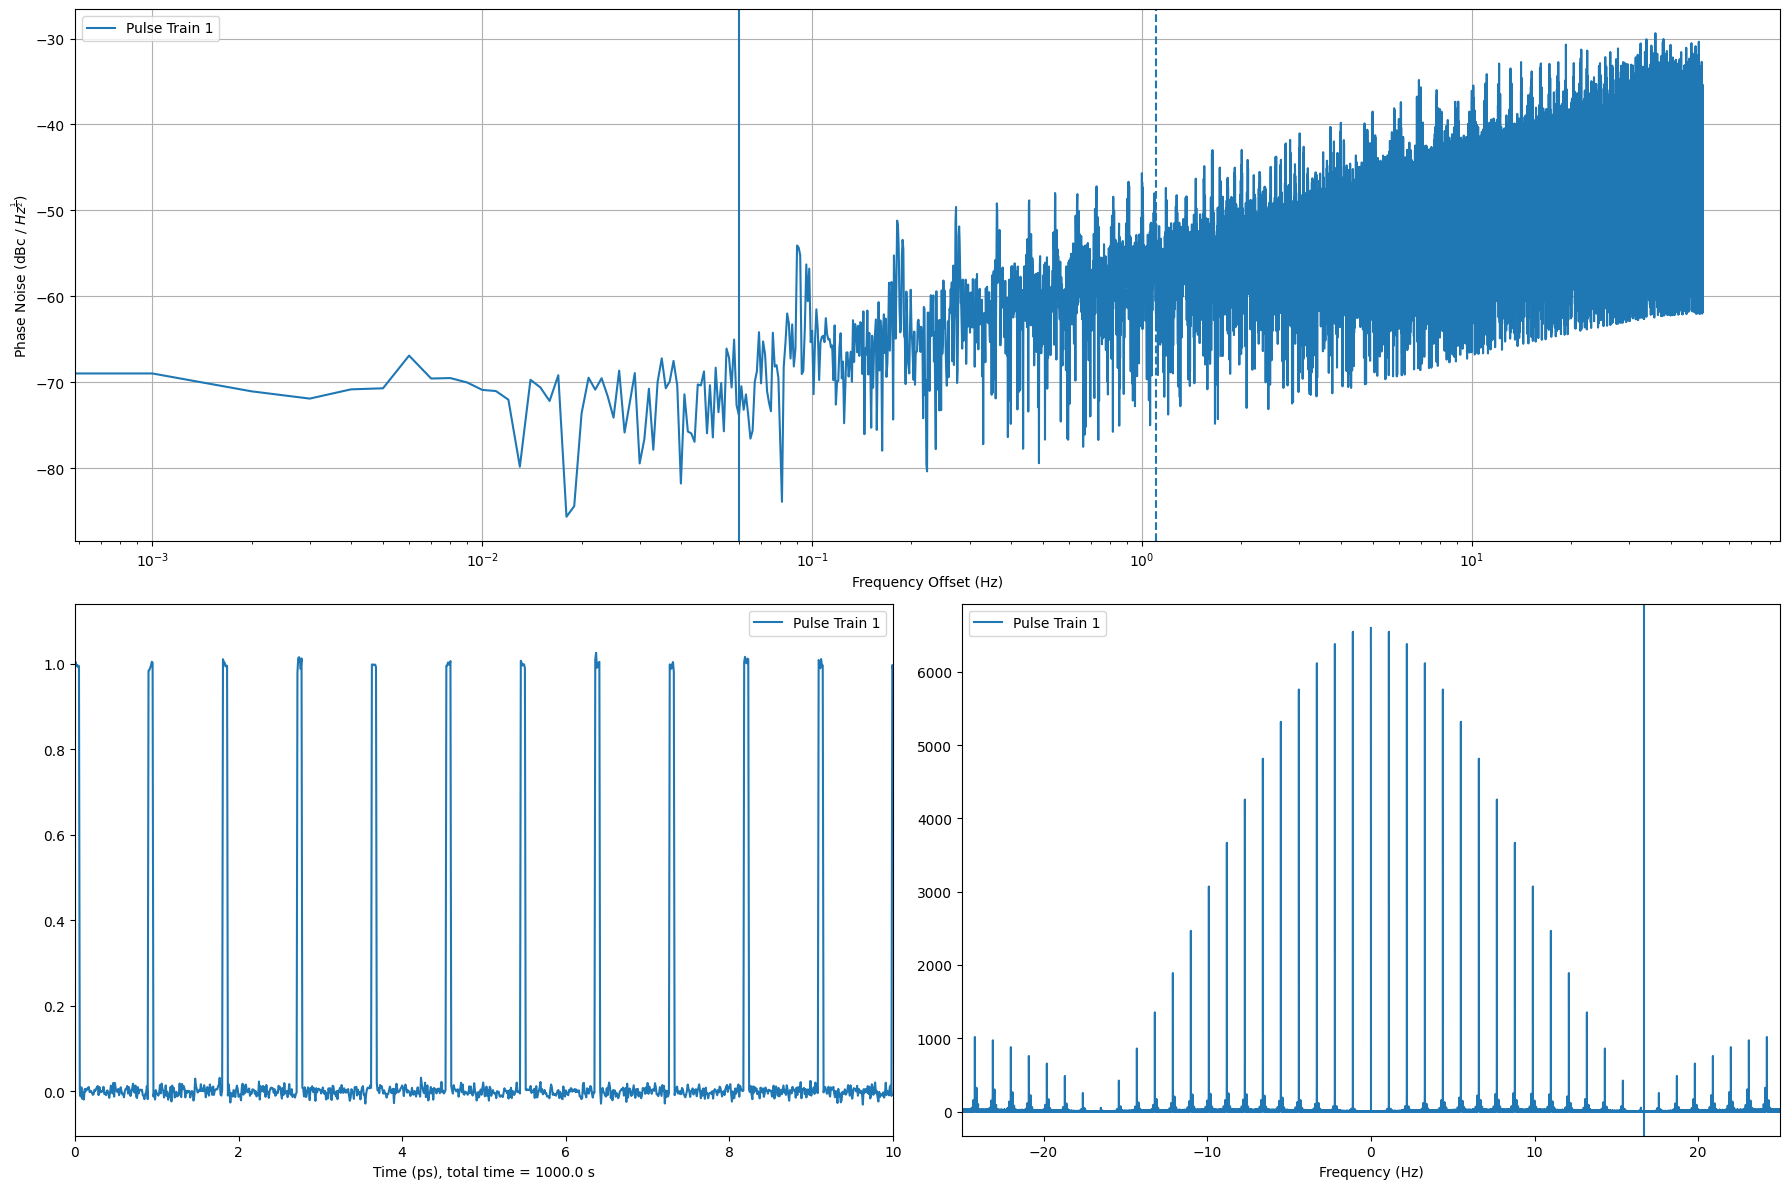

In [5]:
fig = plt.figure(figsize=(18,12),tight_layout=True)
axs = fig.subplot_mosaic([['T', 'T'],['BL', 'BR']],gridspec_kw={'width_ratios':[1, 1]})


for i, param in enumerate(params):
    num_samples = int(param['time'] * param['sample_rate'])
    t = np.linspace(0, param['time'], num_samples, endpoint=False)
    pulse_train = np.zeros_like(t)
    num_pulses = int(param['time'] * param['rep_rate'])
    pulse_samples = int(param['pulse_duration'] * param['sample_rate'])
    pulse_drift = np.linspace(0, param['drift']/param['rep_rate'], num_pulses)*np.exp(np.linspace(0, 100*param['drift'], num_pulses))
    pulse_times_noise = np.random.normal(loc=np.arange(num_pulses) / param['rep_rate'], scale=param['jitter'] / param['rep_rate'], size=num_pulses)
    pulse_times = np.add(pulse_times_noise, pulse_drift)
    
    # GENERATE COMB: PULSE TRAIN & SPECTRUM ####################################
    for pulse_time in pulse_times:
        start_index = int(pulse_time * param['sample_rate'])
        if start_index + pulse_samples < num_samples:
            pulse_train[start_index:start_index + pulse_samples] = 1

    pulse_train += param['noise'] * np.random.normal(size=num_samples)

    frequencies = np.fft.fftfreq(n=num_samples, d=1/param['sample_rate'])
    spectrum = np.fft.fft(pulse_train)

    # TRANSFER FUNCTION ########################################################
    L = 100e-3  # Path length in meters
    c = 3e8   # Speed of light in vacuum, meters per second
    n_0 = param['n_0'] #refractive index
    alpha_0 = param['alpha_0'] #apbsorption coefficient
    nt = n_0 + 0.1*  np.sin(frequencies*2*np.pi) 
    alpha = alpha_0 * np.exp(-frequencies / 1.5e14) 
    H_absorption = np.exp(-alpha * L)
    H_phase = np.exp(-1j * 2 * np.pi * frequencies * (nt - 1) * L / c)
    H = H_absorption * H_phase

    mod_spectrum = spectrum * H
    
    # PHASE NOISE #############################################################
    phase_angles = np.angle(mod_spectrum)
    phase_diff = np.diff(phase_angles)  # Difference between phases
    # phase_diff = np.diff(spectrum)
    # spec_diff = np.diff(spectrum)
    # phase_diff = np.angle(spec_diff)
    power_spec_dens = np.abs(np.fft.ifft(phase_diff))**1 # Power spectral density
    pnd = 10 * np.log10(power_spec_dens / param['sample_rate'])  # Convert to dBc/Hz

    combs.append({})
    combs[i]['frequencies'] = frequencies
    combs[i]['pnp'] = power_spec_dens
    combs[i]['mod_spectrum'] = mod_spectrum
    combs[i]['pulse_train'] = pulse_train

    if i == 0:
        comb1['frequencies'] = frequencies
        comb1['pnp'] = power_spec_dens
        comb1['mod_spectrum'] = mod_spectrum
        comb1['pulse_train'] = pulse_train
    elif i == 1:
        comb2['frequencies'] = frequencies
        comb2['pnp'] = power_spec_dens
        comb2['mod_spectrum'] = mod_spectrum
        comb2['pulse_train'] = pulse_train
    if i==0:
    # PLOT #####################################################################
        axs['T'].semilogx(frequencies[:num_samples//2], pnd[:num_samples//2], label=f'Pulse Train {i+1}')
    # axs['T'].semilogx(frequencies[:num_samples-1], pnd[:num_samples])
    # axs['T'].semilogx(frequencies[:num_samples-1], pnp[:num_samples])
    # axs['T'].semilogx(frequencies[:num_samples//2]/1e6, 10*np.log10(1/(frequencies[:num_samples//2]*1e-3)), 'r--')
        axs['T'].axvline(param['rep_rate'], linestyle='--')#, label=f'Rep Rate {i+1}')
        axs['T'].axvline(param['pulse_duration'])
        axs['T'].set_xlabel('Frequency Offset (Hz)')
        axs['T'].set_ylabel(r'Phase Noise (dBc / $Hz^{\frac{1}{2}}$)')
    # axs['T'].set_xlim(1e-0, 1e6)
    # axs['T'].set_ylim(-200, -0)
        axs['T'].grid(True)
        axs['T'].legend()

        axs['BL'].plot(t, pulse_train, label=f'Pulse Train {i+1}')
        axs['BL'].set_ylim(np.max(pulse_train) * np.array([-0.1, 1.1]))
        axs['BL'].set_xlabel(f'Time (ps), total time = {param['time']} s')
        axs['BL'].set_xlim(0, len(t)/10000)
        axs['BL'].legend()

        axs['BR'].plot(frequencies, np.abs(mod_spectrum), label=f'Pulse Train {i+1}')
        axs['BR'].axvline(16.666)
        axs['BR'].axvline(33.333)
        axs['BR'].set_xlabel('Frequency (Hz)')
        axs['BR'].set_xlim(-25, 25)
        axs['BR'].legend()

plt.tight_layout()
plt.show()


## More Dynamic Comb Generation
 * Combs are generated via a waveform that has variable pulse bandwidth, number of modes included in the pulse, and phase modulation for CEP slip simulation
 * Pulse width (duration) is inversley related to bandwidth of comb
 * Comb tooth spacing is the inverse of the repetition rate
 * Phase slip will modulate wavepacket (pulse) from which we can calculate f0 offset -- need to verify if we can correctly identify this with self referencing heterodyne detection
 * Repetition rate must be consistent
    * comb will be generated based off a set number of pulses in a 0 to 1 interval and will need to be dimensionalized. The signal x-axis must be consistent with the repetition rate values of the comb, but the center position can be moved arbitrarily within reason


In [6]:
def calc_pulse(xnum, a, m=1/(2*np.pi), l=500, t=1.0, h=1.0):
    """
    a: Bandwidth (inverse).
    m: Phase evolution with no x axis evolution.
    """
    yvals = []
    xvals = np.linspace(-1,1,xnum)
    for x in xvals:
        y = (1/np.pi ** 0.25) * (np.exp(complex(-1e3*a*x**2, l*(x)-h*l**2*t/2/m)/(1+2*h*0.5*t/4)**0.5))
        yvals.append(y.real)
    return yvals


In [18]:

def generate_pulse(xnum,a,drift=0.0,slip=0.0,num=100):
    pulse = calc_pulse(xnum, a, m=1/(2*np.pi), l=200, t=1.0, h=1.0)
    m=1/(2*np.pi)

    phase_slip_list=[]
    for i in range(num-1):
        m += 1/(2*np.pi) * slip
        pulse_slipped = calc_pulse(xnum, a, m)

        max_index = np.argmax(pulse_slipped)
        phase_slip_list.append(np.abs(np.linspace(-1,1,xnum)[max_index]))

        pulse_drift_fill = np.concatenate((pulse,np.array([0]*int(drift*i))),axis=0)
        pulse = np.concatenate((pulse_drift_fill,pulse_slipped),axis=0)

    normalized_xvals = np.linspace(0,1,len(pulse))

    f0 = 1/(2*np.pi) * num * np.average(phase_slip_list)
    print(f'CEP Phase Slip: {np.average(phase_slip_list)}. Relative frequency offset (f0): {f0}')
    
    return pulse, f0


In [46]:
xnum = 10000

pulse_1, f0_1 = generate_pulse(xnum, a=10.0, drift=0.00, slip=0.01, num=50)
# pulse_2, f0_2 = generate_pulse(1e5, 1.0, drift=0.00, slip=0.01, num=100)
# pulse_3, f0_3 = generate_pulse(1e5, 1.0, drift=0.00, slip=0.01, num=100)

normalized_xvals = np.linspace(0,1,len(pulse_1))

frequency_vals = np.fft.fftfreq(len(normalized_xvals),d=1/xnum)
spectrum_vals = np.abs(np.fft.fft(pulse_1))

CEP Phase Slip: 0.0034146271770034006. Relative frequency offset (f0): 0.027172739701800775


### Here we can extrapolate comb to see offset/ phase slip modulation

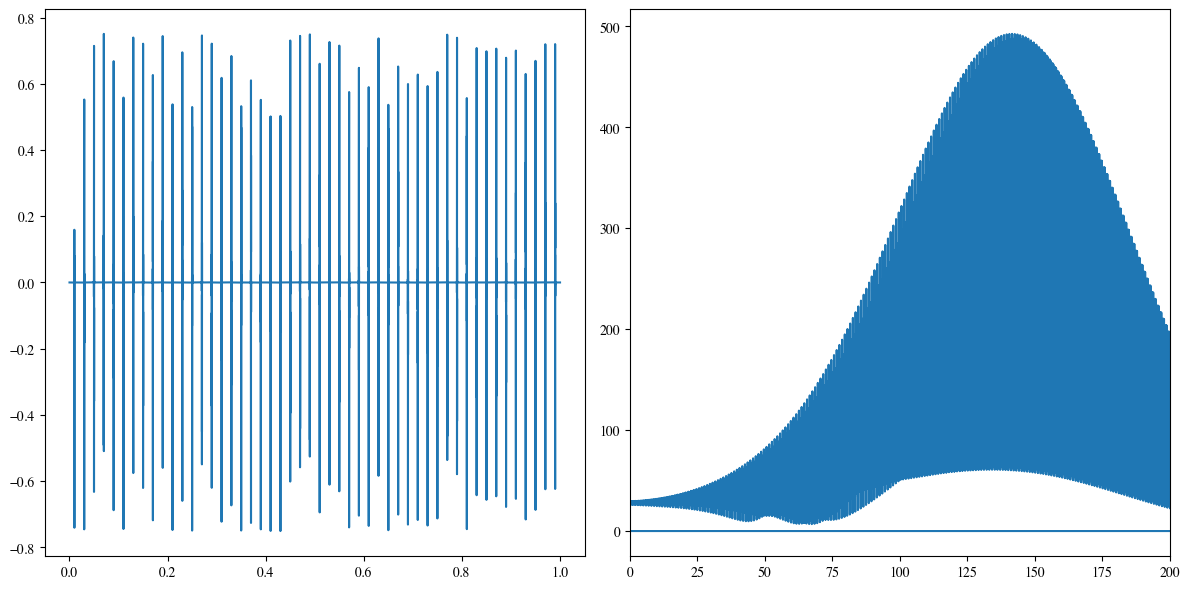

In [47]:
fig = plt.figure(figsize=(12,6),tight_layout=True)
axs = fig.subplot_mosaic([['TL', 'TR']],gridspec_kw={'width_ratios':[1, 1]})
axs['TR'].plot(frequency_vals,spectrum_vals)
axs['TR'].set_xlim(0,200)

axs['TL'].plot(normalized_xvals,pulse_1)


### We can arbitrarily shift this comb up or down the frequecny scale as long as teeth separation is not changed
 * Whatever scale comb is moved to must be consistent with xaxis of signal data

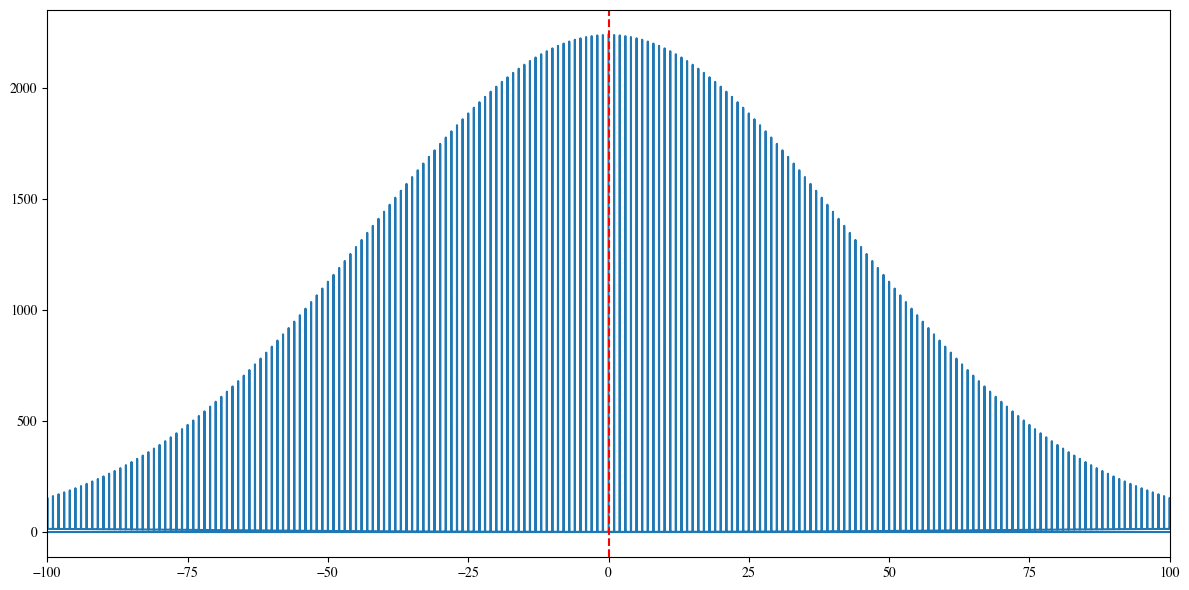

In [48]:
comb_vals = np.abs(np.fft.fft(np.abs(pulse_1)))

fig = plt.figure(figsize=(12,6),tight_layout=True)
plt.plot(frequency_vals, comb_vals)
plt.xlim(-100,100)
plt.axvline(f0_1, color='r', linestyle='--')

### Extra code to analyze phase slip and phase vs. group velicity (i.e. CEP stabilization) --- not sure how useful this is/will be yet

In [24]:
nu = 0.29  # Poisson's ratio of bar material.
l_ratios = np.arange(0, 2.01, 0.01).astype(complex)  # Normalised wavelength range to calculate.

# Bancroft phase velocity
def bancroft(v_ratio, l_ratio, nu):
    a = 1
    L = (2 * a) / l_ratio
    x = (v_ratio ** 2) * (1 + nu)
    beta = (1 - 2 * nu) / (1 - nu)
    h = (2 * np.pi / L) * np.sqrt(beta * x - 1)
    k = (2 * np.pi / L) * np.sqrt(2 * x - 1)
    Jha = h * a * jn(0, h * a) / jn(1, h * a)
    Jka = k * a * jn(0, k * a) / jn(1, k * a)
    return (x - 1) ** 2 * Jha - (beta * x - 1) * (x - Jka)  # out = 0 for valid roots

# Phase velocities via bisection
def find_phase_velocity(l_ratios, nu):
    v_ratios = np.ones(len(l_ratios)).astype(complex)  # Normalised phase velocity.
    tolerance = 1e-6  # Allowable tolerance.
    
    for i in range(1, l_ratios.shape[0]):
        l_ratio = l_ratios[i]  # Ratio of diameter to wavelength: d/L.
        high = v_ratios[i - 1]  # Initial guess interval high limit.
        low = 0  # Initial guess interval low limit.
        v_ratio = (low + high) / 2  # Initial v_ratio guess.
        result = bancroft(v_ratio, l_ratio, nu)  # Initial result from Bancroft's equation.

        while abs(result) > tolerance:
            if result > 0:
                high = v_ratio
            else:
                low = v_ratio
            v_ratio = (low + high) / 2
            result = bancroft(v_ratio, l_ratio, nu)
        v_ratios[i] = v_ratio
        
    return v_ratios

v_ratios = find_phase_velocity(l_ratios, nu)
norm_freqs = (l_ratios / 2) * v_ratios  # Normalised frequencies, f*a/c0.


/var/folders/tl/2hjtn9nn2cv6j4rb1nygnp9c0000gn/T/ipykernel_2336/3204512827.py:6: RuntimeWarning: invalid value encountered in divide
  Jha = ha * jn(0, ha) / jn(1, ha)
/var/folders/tl/2hjtn9nn2cv6j4rb1nygnp9c0000gn/T/ipykernel_2336/3204512827.py:7: RuntimeWarning: invalid value encountered in divide
  Jka = ka * jn(0, ka) / jn(1, ka)
/Users/jackdiab/.pyenv/versions/3.12.0/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jackdiab/.pyenv/versions/3.12.0/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


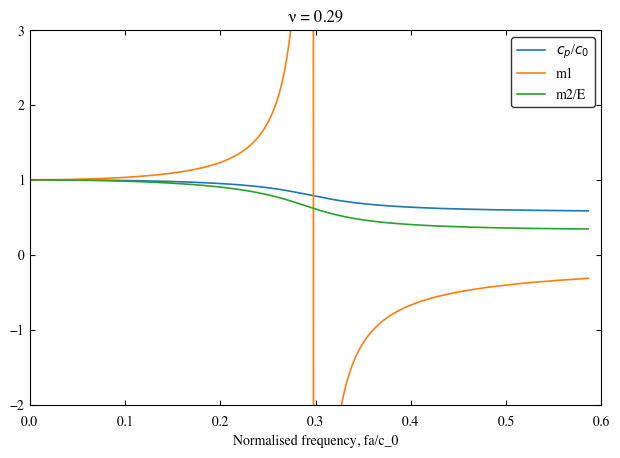

In [23]:
# Calculate m1 and m2 factors
S = (1 - 2 * nu) / (1 - nu)
Z = (1 + nu) * (v_ratios ** 2)
ha = (l_ratios / 2) * (2 * np.pi) * np.sqrt(S * Z - 1)
ka = (l_ratios / 2) * (2 * np.pi) * np.sqrt(2 * Z - 1)
Jha = ha * jn(0, ha) / jn(1, ha)
Jka = ka * jn(0, ka) / jn(1, ka)

m1 = np.real((2 * (1 + (1 - S * Z) / (Z - 1))) / (Jha + ((1 - S * Z) / (Z - 1)) * Jka))  # Factor M_1
m1[0] = 1  # Above equation contains a division by zero at l_ratio = 0. Assume M_1(1) = 1.
m2 = v_ratios ** 2  # Normalised factor M_2 (M_2/E).

# Plotting
plt.figure()
plt.rcParams.update({'font.family': 'Times'})
plt.xlabel('Normalised frequency, fa/c_0')
plt.title(f'\u03BD = {nu}')
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.tick_params(axis='x', pad=8)
plt.plot(norm_freqs, v_ratios, label='$c_{p}$/$c_{0}$', linewidth=1.2)
plt.plot(norm_freqs, m1, label='m1', linewidth=1.2)
plt.plot(norm_freqs, m2, label='m2/E', linewidth=1.2)
plt.tight_layout(pad=1.5)
plt.legend(loc='upper right', edgecolor='black')
plt.ylim(-2, 3)
plt.xlim(0, 0.6)
plt.show()

*** Need to add better shifting and alignment of comb and signal ***

## Start of Matty's code for adding noise

In [7]:
def spectrumNoise(spectrum, noise_param):
    M = np.diag(spectrum)
    N = np.zeros(M.shape)
    #np.array([[np.exp(-(j-i)*(j-i)/(2*noise_param*noise_param))/np.sqrt(2*np.pi*noise_param*noise_param) for j in range(spectrum.size)] for i in range(spectrum.size)] )
    shiftFactor=int(spectrum.size/2)
    vect = np.array([np.exp(-(j-spectrum.size/2)*(j-spectrum.size/2)/(2*noise_param*noise_param))/np.sqrt(2*np.pi*noise_param*noise_param) for j in range(spectrum.size)])
    for i in range(int(spectrum.size/2)):
        N[i+shiftFactor,i:]+=vect[i:]
    for i in range(int(spectrum.size/2)+1):
        N[shiftFactor-(i+1),:-(i+1)]+=vect[:-(i+1)]
        if(shiftFactor-(i+1)<0): print(i,shiftFactor)
    return(np.sum(M@N,axis=0))
def spectrumNoise2(spectrum, noise_param):
    M = np.diag(spectrum)
    N = np.zeros(M.shape)
    #np.array([[np.exp(-(j-i)*(j-i)/(2*noise_param*noise_param))/np.sqrt(2*np.pi*noise_param*noise_param) for j in range(spectrum.size)] for i in range(spectrum.size)] )
    shiftFactor=int(spectrum.size/2)
    vect = np.array([np.exp(-(j-spectrum.size/2)*(j-spectrum.size/2)/(2*noise_param*noise_param))/np.sqrt(2*np.pi*noise_param*noise_param) for j in range(spectrum.size)])
    print(vect,np.concatenate((vect[shiftFactor:],vect[:shiftFactor]),axis=0))
    for i in range(int(spectrum.size/2)):
        N[i+shiftFactor]+=np.concatenate((vect[i:],vect[:i]),axis=0)
    for i in range(int(spectrum.size/2)):
        N[shiftFactor-(i+1)]+=np.concatenate((vect[:-(i+1)],vect[-(i+1):]),axis=0)
    return(np.sum(M@N,axis=0))

def spectrumNoise3(spectrum, noise_param):
    M = np.diag(spectrum)
    N = np.zeros(M.shape)
    #np.array([[np.exp(-(j-i)*(j-i)/(2*noise_param*noise_param))/np.sqrt(2*np.pi*noise_param*noise_param) for j in range(spectrum.size)] for i in range(spectrum.size)] )
    shiftFactor=int(spectrum.size/2)
    runningVect=np.zeros(spectrum.size)
    vect = np.array([np.exp(-(j-spectrum.size/2)*(j-spectrum.size/2)/(2*noise_param*noise_param))/np.sqrt(2*np.pi*noise_param*noise_param) for j in range(spectrum.size)])
    #return(vect)
    #return(np.concatenate((vect[-2000:],vect[:-2000]),axis=0))
    for i in range(int(spectrum.size/2)):
        runningVect+=np.concatenate((vect[i:],vect[:i]),axis=0)*spectrum[shiftFactor-i]
    for i in range(int(spectrum.size/2)):
        runningVect+=np.concatenate((vect[-(i+1):],vect[:-(i+1)]),axis=0)*spectrum[shiftFactor+(i)]
    return(runningVect)

In [8]:
methaneIR = jc.jcamp_readfile('74-82-8-IR.jdx')
ethyneIR = jc.jcamp_readfile('74-86-2-IR.jdx')
ammoniaIR = jc.jcamp_readfile('7664-41-7-IR.jdx')

In [9]:

data1X,data1Y = methaneIR['x'],methaneIR['y']
data2X,data2Y = ethyneIR['x'],ethyneIR['y']
data3X,data3Y = ammoniaIR['x'],ammoniaIR['y']
#np.savetxt('spectrumCH4.csv', (methaneIR['x'],methaneIR['y']), delimiter=',')
#np.savetxt('spectrumC2H2.csv', (ethyneIR['x'],ethyneIR['y']), delimiter=',')

#plt.plot(data1X,data1Y)
#plt.plot(data2X,data2Y)

#orderedfreq=np.concatenate( (comb1['frequencies'][50001:100000],comb1['frequencies'][0:50000]),axis=0)
#orderedspectrum=np.concatenate( (comb1['mod_spectrum'][50001:100000],comb1['mod_spectrum'][0:50000]),axis=0)

#subfreq=orderedfreq[32085:67915]
#subspec=orderedspectrum[32085:67915]

def decimateAvg(L,newSize):
    '''decreasing resolution'''
    factor = int(L.size/newSize)
    newL=np.zeros(newSize,dtype=np.complex128)
    for i in range(newSize):
        count=0
        for j in range(factor):
            count+=L[i*factor+j]

        newL[i]=count/factor

    return(newL)

def decimateMax(L,newSize):
    '''decreasing resolution'''
    factor = int(L.size/newSize)
    newL=np.zeros(newSize,dtype=np.complex128)
    for i in range(newSize):
        count=0+0j
        for j in range(factor):
            if(np.abs(count)<np.abs(L[i*factor+j])):count=L[i*factor+j]

        newL[i]=count

    return(newL)

def dexiplyBlock(L, newSize):
    '''increasing resoldaution'''
    factor = int(np.ceil(newSize/L.size))
    newL=np.zeros(newSize,dtype=np.complex128)
    marker=0
    for i in range(newSize):
        newL[i]=L[marker]
        if int((marker+1)*factor<i):marker+=1
        
    return(newL)

def dexiplyLinear(L,newSize):
    '''increasing resolution (linear interpolation)'''
    factor =np.ceil(newSize/L.size)
    newL=np.zeros(newSize,dtype=np.complex128)
    marker=0
    for i in range(newSize):
        if factor*(marker+1)==i:
            newL[i]=L[marker]
            marker+=1
        elif marker+1<L.size:
            newL[i]=((marker+1.0)-(i+0.0)/(factor+0.0))*L[marker]+(0.0-marker+(i+0.0)/(factor+0.0))*L[marker+1]
        else:newL[i]=L[-1]
    return(newL)


def randIR(spec,noise):
    '''adding noise to IR spectrum'''
    return(spec+np.random.normal(0,noise,spec.size))


#orderedspectrum=np.concatenate( (comb1['mod_spectrum'][17501:35000],comb1['mod_spectrum'][0:17501]),axis=0)
#data1YPrime=dexiplyLinear(data1Y,27000)
#data1YPrime2=dexiplyBlock(data1Y,35000)
'''
data1XPrime=dexiplyLinear(data1X,27000)
combPrime=decimateAvg(orderedspectrum,3500)
data11Y=data1Y*combPrime
data22Y=data2Y*combPrime
'''

orderComb1 = np.concatenate( (combs[0]['mod_spectrum'][int(combs[0]['mod_spectrum'].size/2)+1:combs[0]['mod_spectrum'].size], combs[0]['mod_spectrum'][0:int(combs[0]['mod_spectrum'].size/2)]), axis=0)
verticalNoiseIR = 0.2
verticalNoiseIR2 = 0.05
orderComb=[]

noisyCH4_IR=[]
combsCH4 =[]
precombsCH4 =[]

combsC2H2 = []
precombsC2H2 = []
noisyC2H2_IR=[]

combsNH3 = []
precombsNH3 = []
noisyNH3_IR=[]

smoothing_param = 20
#this code takes the spectra and reorders them, it also adds the "noise" to the IR
for k in range(3*numberOfCombs):
    orderComb.append(np.concatenate( (combs[k]['mod_spectrum'][int(combs[k]['mod_spectrum'].size/2)+1:combs[k]['mod_spectrum'].size], combs[k]['mod_spectrum'][0:int(combs[k]['mod_spectrum'].size/2)]), axis=0))
    if(k<numberOfCombs+1): 
        noisyCH4_IR.append(randIR(spectrumNoise3(randIR(methaneIR['y'],verticalNoiseIR),smoothing_param),verticalNoiseIR2))
        precombsCH4.append(orderComb[k][range1:range2])
        combsCH4.append(dexiplyLinear(noisyCH4_IR[-1], orderComb[k][range1:range2].size)*orderComb[k][range1:range2])
    elif(k<2*numberOfCombs+1):
        noisyC2H2_IR.append(randIR(spectrumNoise3(randIR(ethyneIR['y'],verticalNoiseIR),smoothing_param),verticalNoiseIR2))
        precombsC2H2.append(orderComb[k][range1:range2])
        combsC2H2.append(dexiplyLinear(noisyC2H2_IR[-1], orderComb[k][range1:range2].size)*orderComb[k][range1:range2])
    else:
        noisyNH3_IR.append(randIR(spectrumNoise3(randIR(ammoniaIR['y'],verticalNoiseIR),smoothing_param),verticalNoiseIR2))
        precombsNH3.append(orderComb[k][range1:range2])
        combsNH3.append(dexiplyLinear(noisyNH3_IR[-1], orderComb[k][range1:range2].size)*orderComb[k][range1:range2])


''' Creating data files (so I could distribute it to the team)
np.save('CH4dataPostComb',combsCH4)
np.save('CH4Combs',combsCH4)
np.save('CH4IRspectra',noisyCH4_IR)

np.save('C2H2dataPostComb',combsC2H2)
np.save('C2H2Combs',combsC2H2)
np.save('C2H2IRspectra',noisyC2H2_IR)



np.save('CH4_Data_6_27',combsCH4)
np.save('C2H2_Data_6_27',combsC2H2)
np.save('NH3_Data_6_27',combsNH3)
'''


modComb1 = dexiplyLinear(data1Y, orderComb1[range1:range2].size)*orderComb1[range1:range2] #passing the methane IR through the 0th comb in the -10 to 10 range
modAxis1 = dexiplyLinear(data1X, orderComb1[range1:range2].size)
modComb2 = dexiplyLinear(data2Y, orderComb1[range1:range2].size)*orderComb1[range1:range2] #passing the ethyne IR through the 0th comb in the -10 to 10 range
modComb1full = dexiplyLinear(data1Y, orderComb1.size)*orderComb1                        #passing the methane IR through the 0th comb in the full range
modAxis1full = dexiplyLinear(data1X, orderComb1.size)
modComb2full = dexiplyLinear(data2Y, orderComb1.size)*orderComb1                        #passing the ethyne IR through the 0th comb in the -full range





[3 4 5 0 1 2]
459115405.5636879


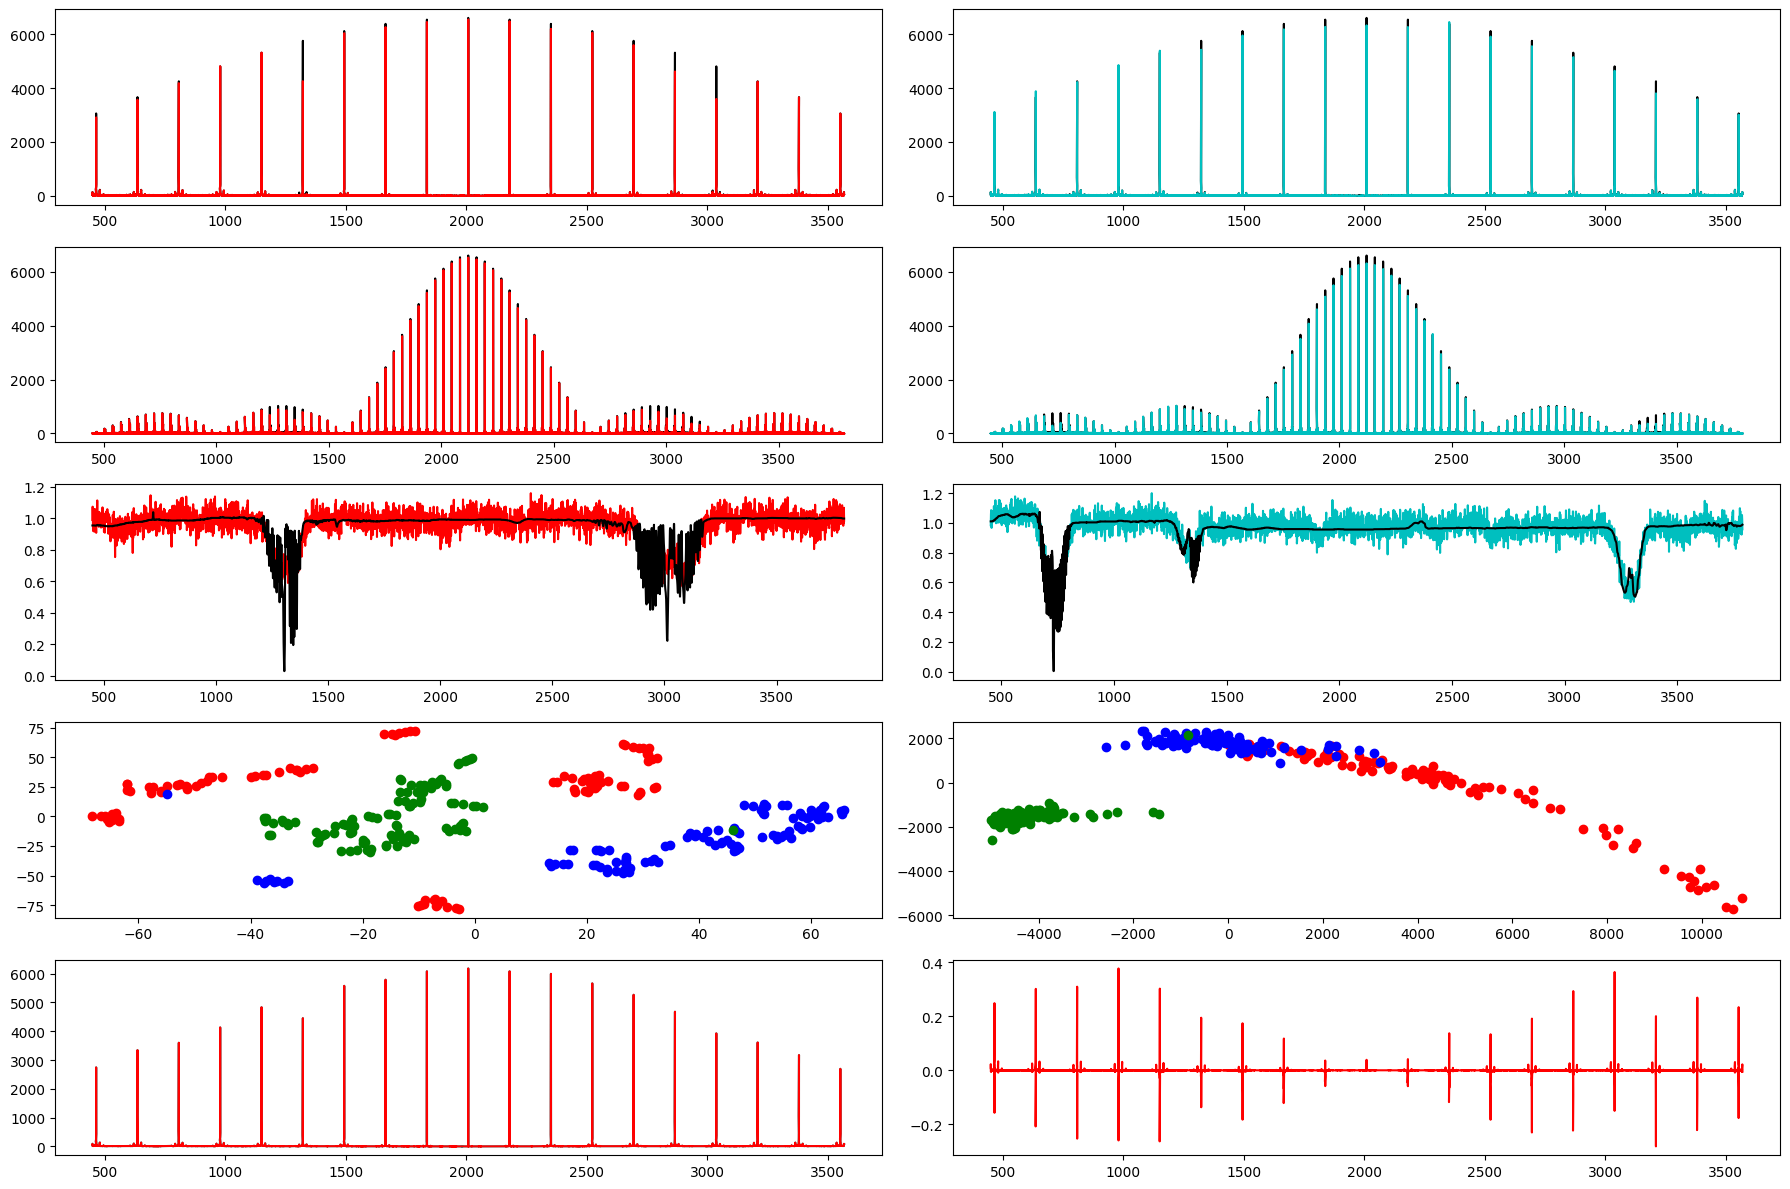

In [10]:


'''Dimension reduction stuff'''

X=np.concatenate((np.abs(combsCH4),np.abs(combsC2H2),np.abs(combsNH3)),axis=0)
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)


pca = PCA(n_components=2)
X_embedded2=pca.fit_transform(X)
importanceVect1,importanceVect2 = pca.inverse_transform([[1,0],[0,1]])
'''No data clustering yet, the colors in the plots indicate which molecules they come from'''

M= [[1,1,1],[2,2,2],[3,3,3]]
v = [0,1,2,3,4,5]
print(np.concatenate((v[3:],v[:3]),axis=0))



fig = plt.figure(figsize=(18,12),tight_layout=True)
axs = fig.subplot_mosaic([['TL','TR'],['BL','BR'],['BBL','BBR'],['BBBL','BBBR'],['BBBBL','BBBBR']],gridspec_kw={'width_ratios':[1, 1]})

axs['TL'].plot(np.abs(modAxis1),np.abs(orderComb1[range1:range2]),c='k')
axs['TL'].plot(np.abs(modAxis1),np.abs(modComb1), c='r')
axs['TR'].plot(np.abs(modAxis1),np.abs(orderComb1[range1:range2]),c='k')
axs['TR'].plot(np.abs(modAxis1),np.abs(modComb2), c='c')

axs['BL'].plot(np.abs(modAxis1full),np.abs(orderComb1),c='k')
axs['BL'].plot(np.abs(modAxis1full),np.abs(modComb1full), c='r')
axs['BR'].plot(np.abs(modAxis1full),np.abs(orderComb1),c='k')
axs['BR'].plot(np.abs(modAxis1full),np.abs(modComb2full), c='c')



axs['BBL'].plot(data1X,noisyCH4_IR[50],c='r')
axs['BBL'].plot(data1X,data1Y,c='k')




axs['BBR'].plot(data2X,noisyC2H2_IR[50],c='c')
axs['BBR'].plot(data2X,data2Y,c='k')


axs['BBBL'].scatter(X_embedded[0:100,0],X_embedded[0:100,1],c='r')
axs['BBBL'].scatter(X_embedded[100:200,0],X_embedded[100:200,1],c='b')
axs['BBBL'].scatter(X_embedded[200:300,0],X_embedded[200:300,1],c='g')


axs['BBBR'].scatter(X_embedded2[0:100,0],X_embedded2[0:100,1],c='r')
axs['BBBR'].scatter(X_embedded2[100:200,0],X_embedded2[100:200,1],c='b')
axs['BBBR'].scatter(X_embedded2[200:300,0],X_embedded2[200:300,1],c='g')



#axs['BBBBL'].plot(data1X,noisyCH4_IR[50],c='r')
#axs['BBBBL'].plot(np.abs(modAxis1),dexiplyLinear(data1Y, orderComb[k][30000:70000].size),c='r')
#axs['BBBBL'].plot(np.abs(modAxis1),dexiplyLinear(data2Y, orderComb[k][30000:70000].size),c='c')

axs['BBBBL'].plot(np.abs(modAxis1),importanceVect1,c='c')
axs['BBBBL'].plot(np.abs(modAxis1),importanceVect2,c='r')


#axs['BBBBR'].plot(data2X,noisyC2H2_IR[50],c='c')
#axs['BBBBR'].plot(np.abs(modAxis1),dexiplyLinear(data1Y, orderComb[k][30000:70000].size),c='r')
#axs['BBBBR'].plot(np.abs(modAxis1),dexiplyLinear(data2Y, orderComb[k][30000:70000].size),c='c')
axs['BBBBR'].plot(np.abs(modAxis1),importanceVect2-importanceVect1,c='r')
#axs['BBBBR'].plot(np.abs(modAxis1),importanceVect1,c='c')

print(np.sum(importanceVect1*importanceVect2))

#plt.plot(data1X, np.abs(combPrime), color='green')
#plt.plot(data1X, np.abs(data11Y))
#plt.plot(data1X, np.abs(data22Y))
#plt.plot(data1XPrime,data1YPrime)
#plt.plot(data1XPrime,data1YPrime2)




## Adding noisy data to updated comb

In [49]:
#convert wavenumbers to frequency in MHz
def wn_to_freq(data1X):
    c = 2.998e10 
    freqs = np.array(data1X) * c / 1e6
    return freqs


# Heterodyning

/var/folders/tl/2hjtn9nn2cv6j4rb1nygnp9c0000gn/T/ipykernel_49396/475629161.py:13: RuntimeWarning: invalid value encountered in sqrt
  phase_noise_dbc_hz = 10 * np.log10(np.array(phase_noise_power)/np.sqrt(np.array(frequencies[1:])) )


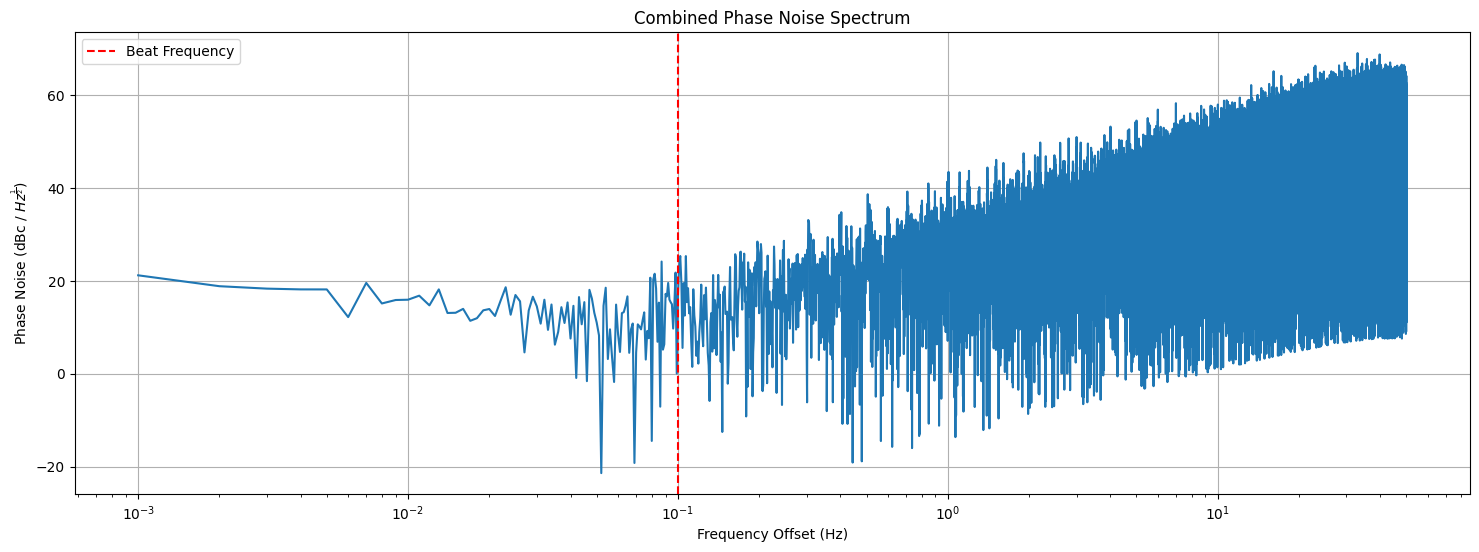

In [ ]:
num = int(params[0]['time'] * params[0]['sample_rate'])
pulse_trains = [comb1['pulse_train'], comb2['pulse_train']]
combined_pulse_train = np.sum([pulse_trains[1]+ pulse_trains[0]], axis=0)
# combined_pulse_train = np.subtract(pulse_trains[1], pulse_trains[0])

fft_result = np.fft.fft(combined_pulse_train)
frequencies = np.fft.fftfreq(num, 1/params[0]['sample_rate'])

phase_angles = np.angle(fft_result)
phase_diff = np.diff(phase_angles) 
# phase_diff = np.diff(fft_result) 
phase_noise_power = np.abs(np.fft.fft(phase_diff))**2
phase_noise_dbc_hz = 10 * np.log10(np.array(phase_noise_power)/np.sqrt(np.array(frequencies[1:])) )

beat = np.abs(params[0]['rep_rate'] - params[1]['rep_rate'])

plt.figure(figsize=(18, 6))
plt.semilogx(frequencies[1:], phase_noise_dbc_hz)
# plt.semilogx(frequencies[:num//2-1], (phase_noise_power/params[0]['sample_rate'])[:num//2-1])
plt.axvline(beat, color='r', linestyle='--', label='Beat Frequency')
plt.title('Combined Phase Noise Spectrum')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Frequency Offset (Hz)')
plt.ylabel(r'Phase Noise (dBc / $Hz^{\frac{1}{2}}$)')
plt.grid(True)
plt.legend()
plt.show()